In [1]:
import pandas as pd
import numpy as np
from tensorflow import device
from keras.layers import Dense, Dropout, GlobalAveragePooling2D
from keras.models import Model
from keras.optimizers import Adam
from keras import callbacks
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.efficientnet_v2 import EfficientNetV2S , preprocess_input
from keras.callbacks import LearningRateScheduler
from sklearn.metrics import classification_report, accuracy_score, f1_score, roc_auc_score
import matplotlib.pylab as plt

In [2]:
img_h = 500
img_w = 500
img_c = 3
batch_size = 32
epochs = 15
data_path = 'dpl-project-1-dog-breed-identification/'

In [3]:
labels_data = pd.read_csv(data_path + 'labels.csv')
labels_data['id'] = labels_data['id'] + '.jpg'
out_dims = len(labels_data['breed'].unique())
out_dims

120

In [4]:
percent_split = np.array([0.8, 0.1, 0.1])
train_size, val_size, test_size = (percent_split * len(labels_data)).round().astype(np.int_).tolist()

train_df = labels_data.sample(train_size, random_state=42)

mask = list(set(labels_data.index) - set(train_df.index))
val_df = labels_data.iloc[mask].sample(val_size, random_state=42)

mask = list(set(labels_data.index) - set(train_df.index) - set(val_df.index))
test_df = labels_data.iloc[mask]

In [5]:
train_df = pd.concat([train_df, val_df])
val_df = test_df

In [6]:
train_gen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    channel_shift_range=10,
    zoom_range=0.1,
    preprocessing_function=preprocess_input
)

val_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

In [7]:
train_flow = train_gen.flow_from_dataframe(dataframe=train_df,   
                                           directory=data_path + 'train',
                                           x_col='id',
                                           y_col='breed',
                                           target_size=(img_h, img_w),
                                           batch_size=batch_size,
                                           class_mode='categorical',
                                           shuffle=True)
val_flow = val_gen.flow_from_dataframe(dataframe=val_df,   
                                        directory=data_path + 'train',
                                        x_col='id',
                                        y_col='breed',
                                        target_size=(img_h, img_w),
                                        batch_size=batch_size,
                                        class_mode='categorical',
                                        shuffle=True)

Found 9200 validated image filenames belonging to 120 classes.
Found 1022 validated image filenames belonging to 120 classes.


In [8]:
efficientnet = EfficientNetV2S(include_top=False, weights='imagenet', input_shape=(img_h, img_w, img_c))
efficientnet.trainable = False
output = GlobalAveragePooling2D()(efficientnet.output)
output = Dropout(0.5)(output)
output = Dense(out_dims, activation='softmax')(output)
model = Model(efficientnet.input, output)

model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [9]:
class LossHistory(callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.lr = []
        
    def on_epoch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
        self.lr.append(step_decay(len(self.losses)))

def step_decay(epoch):
    initial_lrate = 0.001
    drop = 0.1
    epochs_drop = 7
    lrate = initial_lrate * np.power(drop, np.floor((epoch)/epochs_drop))
    return lrate

loss_history = LossHistory()
lrate = LearningRateScheduler(step_decay)
earlystopping = callbacks.EarlyStopping(monitor='val_loss', patience=5, min_delta=0.0001)
callbacks_list = [earlystopping, loss_history, lrate]

In [10]:
with device('/device:gpu:0'):
    history = model.fit(train_flow, validation_data=val_flow, epochs=epochs, callbacks=[callbacks_list])

Epoch 1/15
288/288 [==============================] - 490s 1s/step - loss: 1.4959 - accuracy: 0.7795 - val_loss: 0.3047 - val_accuracy: 0.9364 - lr: 0.0010
Epoch 2/15
288/288 [==============================] - 363s 1s/step - loss: 0.3185 - accuracy: 0.9190 - val_loss: 0.2156 - val_accuracy: 0.9432 - lr: 0.0010
Epoch 3/15
288/288 [==============================] - 353s 1s/step - loss: 0.2591 - accuracy: 0.9261 - val_loss: 0.2006 - val_accuracy: 0.9432 - lr: 0.0010
Epoch 4/15
288/288 [==============================] - 374s 1s/step - loss: 0.2222 - accuracy: 0.9332 - val_loss: 0.1964 - val_accuracy: 0.9452 - lr: 0.0010
Epoch 5/15
288/288 [==============================] - 374s 1s/step - loss: 0.2072 - accuracy: 0.9376 - val_loss: 0.1967 - val_accuracy: 0.9481 - lr: 0.0010
Epoch 6/15
288/288 [==============================] - 359s 1s/step - loss: 0.1893 - accuracy: 0.9407 - val_loss: 0.1884 - val_accuracy: 0.9491 - lr: 0.0010
Epoch 7/15
288/288 [==============================] - 342s 1s/st

<Figure size 640x480 with 0 Axes>

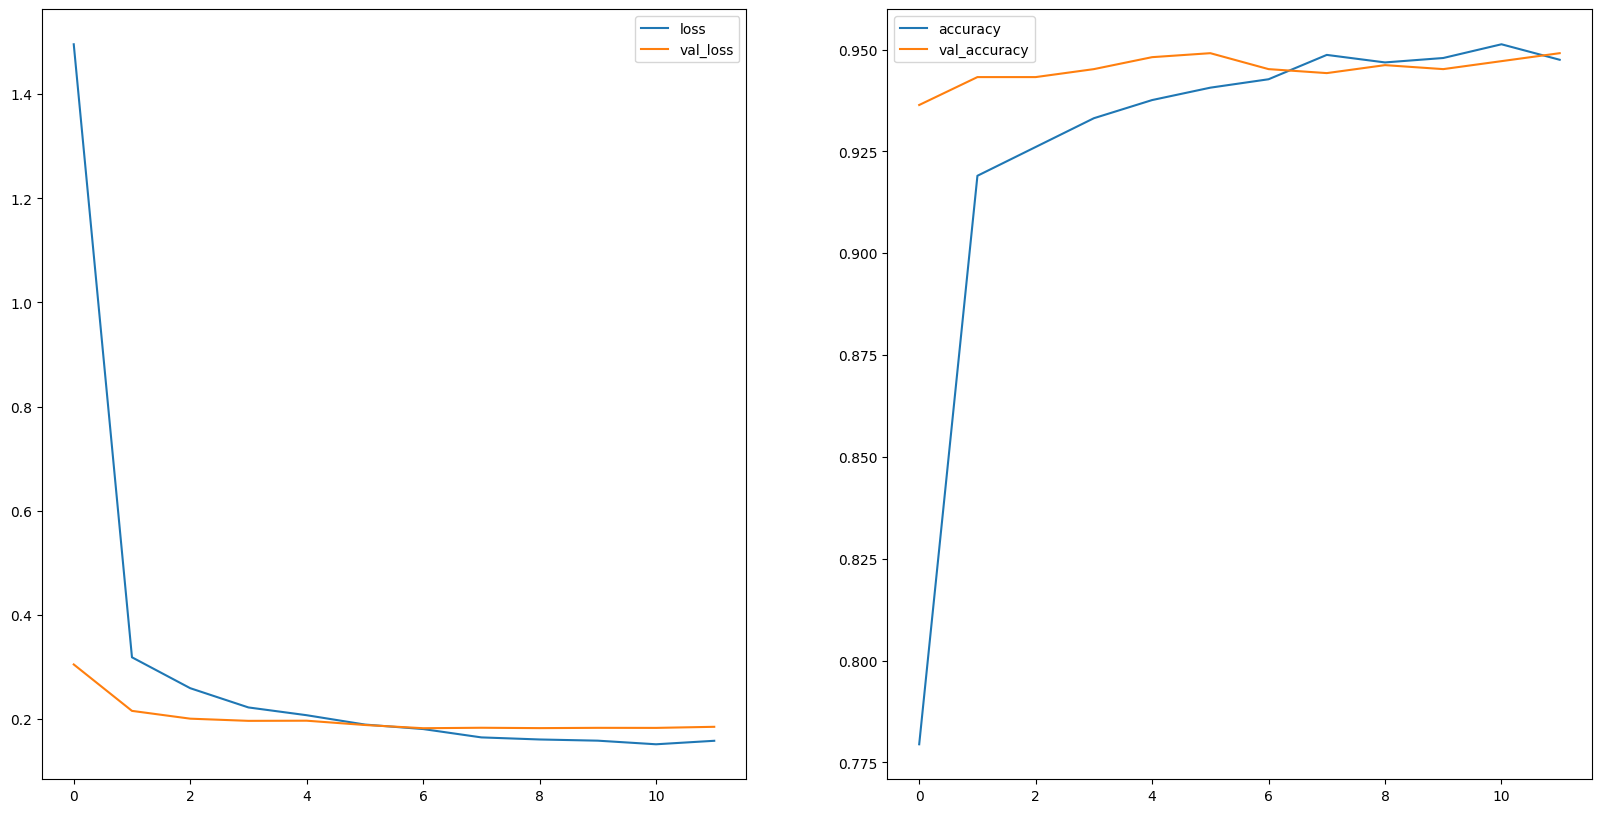

In [11]:
plt.tight_layout()
plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1); plt.plot(history.history['loss'], label='loss'); plt.plot(history.history['val_loss'], label='val_loss'); plt.legend()
plt.subplot(1, 2, 2); plt.plot(history.history['accuracy'], label='accuracy'); plt.plot(history.history['val_accuracy'], label='val_accuracy'); plt.legend()

In [12]:
count = 0
y_true = []
y_prob = []
y_pred = []

for x, y in iter(val_flow):
    y_true.extend(y.argmax(axis=-1))
    y_p = model.predict(x, verbose=0)
    y_pred.extend(y_p.argmax(axis=-1))
    y_prob.extend(y_p)
    count += 1
    if count == len(val_flow):
        break

In [13]:
print(classification_report(y_true, y_pred))
print('accuracy:', accuracy_score(y_true, y_pred))
print('f1-score:', f1_score(y_true, y_pred, average='macro'))
print('roc_auc_score:', roc_auc_score(y_true, y_prob, average='macro', multi_class='ovr'))

model.save('my_model_v3_final.h5')

              precision    recall  f1-score   support

           0       1.00      0.91      0.95        11
           1       1.00      1.00      1.00        14
           2       1.00      1.00      1.00         7
           3       0.88      1.00      0.93        14
           4       1.00      1.00      1.00         7
           5       0.80      0.67      0.73         6
           6       1.00      1.00      1.00         6
           7       1.00      1.00      1.00        10
           8       1.00      1.00      1.00        11
           9       1.00      0.86      0.92        14
          10       1.00      1.00      1.00        10
          11       0.88      1.00      0.93        14
          12       0.91      1.00      0.95        10
          13       1.00      1.00      1.00         9
          14       1.00      1.00      1.00        10
          15       0.92      1.00      0.96        11
          16       0.83      0.83      0.83        12
          17       1.00    